In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import requests
from tqdm import tqdm
from sqlalchemy import create_engine
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import platform
import statsmodels.api as sm
import ssl
import certifi
from urllib.request import urlopen
import json
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from DATA.stock_invest_function import *
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [6]:
matplotlib.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [46]:
# 날짜를 회계분기 말일로 정규화
def normalize_dates_to_quarter_end(df):
    df = df.copy()
    df = df.reset_index()
    df['date'] = pd.to_datetime(df['date']) + pd.offsets.QuarterEnd(0)
    df = df.set_index('date')
    return df

# long-format 변환 함수 (ticker는 컬럼에서 제거하고 별도 컬럼으로 분리)
def reshape_margin_df_for_db(margin_df):
    melted_df = margin_df.reset_index().melt(id_vars=['date', 'ticker'], var_name='accounting_item', value_name='value')
    final_df = melted_df.dropna().sort_values(['accounting_item', 'ticker', 'date'])
    return final_df

# 마진 및 성장률 시계열 데이터 수집 및 long-format 변환
def get_margin_time_series(ticker_list, apikey):
    result_df_list = []

    for ticker in tqdm(ticker_list, desc="Fetching income statements"):
        url = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?period=quarter&limit=100&apikey={apikey}"
        response = requests.get(url)
        if response.status_code != 200:
            print(f"❌ {ticker} API 요청 실패: {response.status_code}")
            continue

        data = response.json()
        df = pd.DataFrame(data)
        if df.empty:
            print(f"❌ {ticker} 수신 데이터 없음.")
            continue

        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)

        # 기본 컬럼 정의
        df['revenue'] = df['revenue']
        df['grossProfit'] = df['grossProfit']
        df['operatingIncome'] = df['operatingIncome']
        df['netIncome'] = df['netIncome']

        # 마진율 계산
        df['GPM'] = df['grossProfit'] / df['revenue']
        df['OPM'] = df['operatingIncome'] / df['revenue']
        df['NPM'] = df['netIncome'] / df['revenue']

        # 성장률 계산
        for col in ['revenue', 'grossProfit', 'operatingIncome', 'netIncome']:
            df[f'{col}_qoq'] = df[col].pct_change(periods=1)
            df[f'{col}_yoy'] = df[col].pct_change(periods=4)

        # 필요한 항목만 추출
        keep_cols = ['revenue', 'grossProfit', 'operatingIncome', 'netIncome',
                     'GPM', 'OPM', 'NPM',
                     'revenue_qoq', 'grossProfit_qoq', 'operatingIncome_qoq', 'netIncome_qoq',
                     'revenue_yoy', 'grossProfit_yoy', 'operatingIncome_yoy', 'netIncome_yoy']

        sub_df = df[keep_cols]
        sub_df = normalize_dates_to_quarter_end(sub_df)
        sub_df['ticker'] = ticker

        result_df_list.append(sub_df)

    # 전체 병합 및 정렬
    if not result_df_list:
        return pd.DataFrame()

    full_df = pd.concat(result_df_list)
    full_df = full_df.replace([np.inf, -np.inf], np.nan)
    full_df = full_df.sort_index()

    return full_df


def load_forecast_by_hscode(db_info, root_hs_code, table_name='trade_forecast_by_month'):
    """
    특정 root_hs_code에 해당하는 예측 데이터를 데이터베이스에서 불러오는 함수

    Parameters:
    - db_info (dict): DB 접속 정보 (host, port, user, password, database)
    - root_hs_code (str or int): 조회할 HS 코드
    - table_name (str): 테이블 이름 (기본값: 'trade_forecast_by_month')

    Returns:
    - pd.DataFrame: 조회된 데이터프레임
    """
    try:
        # ✅ DB 엔진 생성
        engine = create_engine(
            f"mysql+pymysql://{db_info['user']}:{db_info['password']}@{db_info['host']}:{db_info['port']}/{db_info['database']}"
        )

        # ✅ SQL 쿼리 작성 및 실행
        query = f"""
            SELECT *
            FROM {table_name}
            WHERE root_hs_code = '{root_hs_code}'
            ORDER BY period
        """
        df = pd.read_sql(query, con=engine)

        print(f"✅ root_hs_code={root_hs_code}에 해당하는 {len(df)}개 행을 불러왔습니다.")
        return df

    except Exception as e:
        print(f"❌ 데이터 불러오기 실패: {e}")
        return pd.DataFrame()


def get_quarterly_export_forecast(db_info: dict, hs_code: str) -> pd.DataFrame:
    """
    특정 HS 코드를 기준으로 수출 예측 데이터를 불러와 분기별로 정리하는 함수

    Parameters:
    - db_info: dict, MariaDB 접속 정보
    - hs_code: str, 예: '854232' (HS 코드)

    Returns:
    - quarterly_sum_df: DataFrame, 분기별 수출합계 및 qoq/yoy 증가율 포함
    """
    # DB에서 해당 HS코드의 예측 데이터 로드
    target_export_df = load_forecast_by_hscode(db_info, hs_code)
    target_export_df = target_export_df.drop_duplicates(subset=['period'])

    # datetime 변환
    target_export_df['period'] = pd.to_datetime(target_export_df['period'])

    # 분기 추출 및 그룹화
    target_export_df['quarter'] = target_export_df['period'].dt.to_period('Q')
    quarterly_sum_df = target_export_df.groupby('quarter')['expDlr_forecast_12m'].sum().reset_index()

    # datetime 정렬 및 추가 계산
    quarterly_sum_df['quarter'] = quarterly_sum_df['quarter'].dt.to_timestamp()
    quarterly_sum_df['export_qoq_change'] = quarterly_sum_df['expDlr_forecast_12m'].pct_change(periods=1)
    quarterly_sum_df['export_yoy_change'] = quarterly_sum_df['expDlr_forecast_12m'].pct_change(periods=4)
    quarterly_sum_df['date_month'] = quarterly_sum_df['quarter'] + pd.offsets.QuarterEnd(0)

    return quarterly_sum_df


def fit_sarimax_with_exog_gridsearch_model(long_df, ticker, item, export_df, steps=4, pdq_range=(0, 2), seasonal_pdq_range=(0, 2), seasonal_period=4):
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from itertools import product

    df_filtered = long_df[(long_df['ticker'] == ticker) & (long_df['accounting_item'] == item)].copy()
    df_filtered = df_filtered[['date', 'value']].rename(columns={'value': item})
    df_filtered = df_filtered.loc[:, ~df_filtered.columns.duplicated()]
    ts = df_filtered.set_index('date')[item].astype(float)

    export_df_renamed = export_df.rename(columns={'date_month': 'date'})
    export_df_renamed = export_df_renamed.loc[:, ~export_df_renamed.columns.duplicated()]

    merged_df = pd.merge(df_filtered, export_df_renamed[['date', 'export_yoy_change']], on='date', how='inner').sort_values('date')
    exog = merged_df.set_index('date')[['export_yoy_change']].astype(float)
    exog = exog.replace([np.inf, -np.inf], np.nan).dropna()

    common_index = ts.index.intersection(exog.index)
    ts = ts.loc[common_index].sort_index()
    exog = exog.loc[common_index].sort_index()

    export_df = export_df.sort_values(by='date_month').reset_index(drop=True)
    future_exog_df = export_df[export_df['date_month'] > ts.index[-1]][['export_yoy_change']].head(steps)
    future_exog_df = future_exog_df.replace([np.inf, -np.inf], np.nan).dropna()

    if len(future_exog_df) < steps:
        print(f"❌ 미래 외생변수 부족: {len(future_exog_df)}개 → {steps}개 필요")
        return None

    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None

    p = d = q = range(*pdq_range)
    P = D = Q = range(*seasonal_pdq_range)
    s = seasonal_period

    for order in product(p, d, q):
        for seasonal_order in product(P, D, Q):
            seasonal_order_full = (*seasonal_order, s)
            try:
                model = SARIMAX(ts, exog=exog, order=order, seasonal_order=seasonal_order_full,
                                enforce_stationarity=False, enforce_invertibility=False)
                result = model.fit(disp=False)
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = order
                    best_seasonal_order = seasonal_order_full
                    best_model = result
            except Exception as e:
                print(f"❌ 실패: order={order}, seasonal_order={seasonal_order_full} → {str(e)}")

    if best_model is None:
        print("❌ SARIMAX 모델 최적화 실패")
        return None

    forecast_result = best_model.get_forecast(steps=steps, exog=future_exog_df)
    pred_mean = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int()
    future_index = pd.date_range(start=ts.index[-1] + pd.offsets.QuarterEnd(1), periods=steps, freq='Q')

    forecast_df = pd.DataFrame({
        'forecast': pred_mean.values,
        'lower': conf_int.iloc[:, 0].values,
        'upper': conf_int.iloc[:, 1].values
    }, index=future_index)

    print(f"✅ 최적 모델: order={best_order}, seasonal_order={best_seasonal_order}, AIC={best_aic:.2f}")
    return forecast_df


def fit_sarimax_with_no_exog_gridsearch_model(long_df, ticker, item='revenue_yoy', steps=4,
                                  pdq_range=(0, 2), seasonal_pdq_range=(0, 2), seasonal_period=4):
    """
    long_df에서 특정 ticker와 item을 선택하여 SARIMA 예측을 수행하는 함수

    Parameters:
    - long_df: DataFrame, columns = ['ticker', 'accounting_item', 'date', 'value']
    - ticker: str, 기업 코드
    - item: str, 회계 항목명
    - steps: int, 예측 기간
    - pdq_range: tuple, SARIMA(p,d,q) 범위 (e.g. (0, 2) → 0~1)
    - seasonal_pdq_range: tuple, 계절성 SARIMA(P,D,Q) 범위
    - seasonal_period: int, 계절 주기 (예: 4분기 → 4)

    Returns:
    - forecast_df: DataFrame, 예측값 및 신뢰구간 포함
    """

    # 1. 시계열 추출
    df_filtered = long_df[
        (long_df["ticker"] == ticker) &
        (long_df["accounting_item"] == item)
    ][["date", "value"]].rename(columns={"value": item}).copy()

    # 2. 시계열 인덱스 설정
    ts = df_filtered.set_index("date")[item].astype(float).sort_index()

    # ✅ 중복 인덱스 제거
    ts = ts[~ts.index.duplicated(keep='last')]

    # ✅ 빈도 명시 (경고 제거)
    ts = ts.asfreq('Q-DEC')  # 또는 'Q'

    # 3. SARIMA 그리드 서치
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None

    p = d = q = range(*pdq_range)
    P = D = Q = range(*seasonal_pdq_range)
    s = seasonal_period

    for order in product(p, d, q):
        for seasonal_order in product(P, D, Q):
            seasonal_order_full = (*seasonal_order, s)
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    model = SARIMAX(ts, order=order, seasonal_order=seasonal_order_full,
                                    enforce_stationarity=False, enforce_invertibility=False)
                    result = model.fit(disp=False)

                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = order
                    best_seasonal_order = seasonal_order_full
                    best_model = result

            except Exception as e:
                print(f"❌ 실패: order={order}, seasonal_order={seasonal_order_full} → {str(e)}")

    # 4. 예측 수행
    if best_model is None:
        print("❌ SARIMA 모델 최적화 실패")
        return None

    future_index = pd.date_range(start=ts.index[-1] + pd.offsets.QuarterEnd(1), periods=steps, freq='Q')
    forecast_result = best_model.get_forecast(steps=steps)
    pred_mean = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int()

    forecast_df = pd.DataFrame({
        "forecast": pred_mean.values,
        "lower": conf_int.iloc[:, 0].values,
        "upper": conf_int.iloc[:, 1].values
    }, index=future_index)

    print(f"✅ 최적 모델: order={best_order}, seasonal_order={best_seasonal_order}, AIC={best_aic:.2f}")
    return forecast_df


def get_yoy_based_forecast_amounts(long_df, forecast_df, ticker, accounting_item_raw, accounting_item_yoy):
    """
    예측된 YoY 성장률을 이용해 미래 매출 또는 영업이익 수준(raw value)을 예측합니다.

    Parameters:
    - long_df: 원본 데이터프레임
    - forecast_df: SARIMA 예측 결과 (forecast 컬럼 포함)
    - ticker: 기업 코드 (예: 'MU')
    - accounting_item_raw: 원시 항목 (예: 'revenue')
    - accounting_item_yoy: YOY 항목 (예: 'revenue_yoy')

    Returns:
    - forecast_amount_df: 예측된 금액 (raw value) DataFrame
    """

    # ✅ 전년도 해당 분기 값 가져오기 (t-4, t-3, t-2, t-1)
    raw_df = long_df[
        (long_df["ticker"] == ticker) &
        (long_df["accounting_item"] == accounting_item_raw)
    ][["date", "value"]].copy()
    raw_df["date"] = pd.to_datetime(raw_df["date"])
    raw_df = raw_df.set_index("date").sort_index()
    raw_df = raw_df[~raw_df.index.duplicated(keep='last')]

    # ✅ 예측 대상 분기 리스트
    forecast_dates = forecast_df.index

    # ✅ 기준이 되는 전년도 매출값 추출
    reference_dates = [date - pd.DateOffset(years=1) for date in forecast_dates]
    reference_values = raw_df.loc[reference_dates]["value"].values

    # ✅ forecast된 YoY 성장률 적용
    forecast_yoy = forecast_df["forecast"].values
    forecast_values = reference_values * (1 + forecast_yoy)

    forecast_amount_df = pd.DataFrame({
        "forecasted_amount": forecast_values
    }, index=forecast_dates)

    return forecast_amount_df


def apply_growth_to_amount(base_amount_df, growth_df):
    """
    base_amount_df의 forecasted_amount에 대해, growth_df의 YoY 성장률을 곱해서 최종 예측값 생성

    Parameters:
    - base_amount_df: DataFrame, index = 날짜, column = 'forecasted_amount'
    - growth_df: DataFrame, index = 동일한 날짜, column = 'forecast' (비율형 성장률)

    Returns:
    - adjusted_df: DataFrame, column = 'adjusted_amount'
    """
    combined = pd.merge(
        base_amount_df,
        growth_df[["forecast"]],
        left_index=True,
        right_index=True,
        how="inner"
    )

    combined["adjusted_amount"] = combined["forecasted_amount"] * (1 + combined["forecast"])
    return combined[["adjusted_amount"]]

def measure_correl_lstm(long_df, export_df, accounting_item_target, ticker):
    """
    long_df와 export_df를 병합하여 특정 기업의 타겟 회계 항목과 수출 증가율 간의 상관계수를 측정합니다.
    """
    # 1. 회계 항목 필터링 및 정렬
    filtered_df = long_df[long_df['accounting_item'] == accounting_item_target].copy()
    filtered_df = filtered_df.sort_values(by='date')

    # 2. 날짜 컬럼 통일
    export_df = export_df.rename(columns={'date_month': 'date'})

    # 3. 날짜 기준 병합
    merged_df = pd.merge(filtered_df, export_df[['date', 'export_yoy_change']], on='date', how='inner')
    merged_df = merged_df[['date', 'ticker', 'value', 'export_yoy_change']]
    merged_df = merged_df.rename(columns={'value': accounting_item_target})

    # 4. 특정 기업 추출 및 정제
    target_df = merged_df[merged_df['ticker'] == ticker][[accounting_item_target, 'export_yoy_change']]
    target_df = target_df.replace([np.inf, -np.inf], np.nan).dropna()

    # 5. 상관계수 계산
    correlation = target_df[accounting_item_target].corr(target_df['export_yoy_change'])
    return correlation

import pandas as pd

def merge_endog_exog_data(endog_df, exog_df,
                          endog_col, exog_col,
                          start_date=None, end_date=None):
    """
    두 데이터프레임에서 지정한 칼럼을 추출하고 날짜 기준으로 병합합니다.
    """

    # 1. 복사 및 날짜 처리
    endog_df = endog_df.copy()
    exog_df = exog_df.copy()

    # 날짜 → 분기 종료일 → 시간 정보 제거
    # 날짜 → 분기 종료일 → 시간 제거
    endog_df['date'] = pd.to_datetime(endog_df['date']).dt.to_period('Q').dt.to_timestamp(how='end').dt.normalize()
    exog_df['date'] = pd.to_datetime(exog_df['date']).dt.to_period('Q').dt.to_timestamp(how='end').dt.normalize()

    # 2. 외생변수는 중복 제거
    exog_df = exog_df.groupby('date')[exog_col].last().reset_index()

    # 3. 날짜 필터링
    if start_date:
        start = pd.to_datetime(start_date)
        endog_df = endog_df[endog_df['date'] >= start]
        exog_df = exog_df[exog_df['date'] >= start]
    if end_date:
        end = pd.to_datetime(end_date)
        endog_df = endog_df[endog_df['date'] <= end]
        exog_df = exog_df[exog_df['date'] <= end]

    # 4. 필요한 칼럼 추출
    endog_df = endog_df[['date', endog_col]]
    exog_df = exog_df[['date', exog_col]]

    # 5. 병합
    merged_df = pd.merge(endog_df, exog_df, on='date', how='inner')

    # 6. 열 이름 변경
    merged_df.rename(columns={
        endog_col: 'endog_var',
        exog_col: 'exog_var'
    }, inplace=True)

    return merged_df



def sarima_forecast_with_log_option(df, date_col='date', value_col='endog_var', use_log=1):
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from statsmodels.stats.diagnostic import acorr_ljungbox
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from sklearn.metrics import mean_absolute_error
    import matplotlib.pyplot as plt
    import numpy as np
    from itertools import product
    import pandas as pd

    # ✅ 1. 중복 제거: 같은 날짜가 여러 행에 있을 경우 마지막 값만 사용
    df_clean = df.groupby(date_col)[value_col].last().reset_index()

    # ✅ 2. 시계열로 변환
    ts = df_clean.set_index(date_col)[value_col].asfreq('Q')

    # ✅ 3. 로그 변환
    if use_log:
        ts = np.log(ts)
        print("✅ 로그 변환 적용")

    # 4. Train/Test 분리
    train = ts.iloc[:-4]
    test = ts.iloc[-4:]

    # 5. SARIMA 파라미터 탐색
    p = d = q = P = D = Q = [0, 1]
    s = 4
    param_combinations = list(product(p, d, q))
    seasonal_combinations = list(product(P, D, Q))
    total_combinations = list(product(param_combinations, seasonal_combinations))

    best_aic = np.inf
    best_model = None
    best_order = None
    best_seasonal = None

    print(f"🔍 총 {len(total_combinations)}개의 SARIMA 조합 평가 중...")

    for (order, seasonal) in total_combinations:
        seasonal_order = (*seasonal, s)
        try:
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
            result = model.fit(disp=False)
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = order
                best_seasonal = seasonal_order
                best_model = result
        except:
            continue

    print(f"\n✅ 최적 SARIMA 구조: order={best_order}, seasonal_order={best_seasonal}, AIC={best_aic:.2f}")

    # 6. 예측
    forecast_log = best_model.forecast(steps=4)
    forecast = np.exp(forecast_log) if use_log else forecast_log
    test_true = np.exp(test) if use_log else test

    # 7. MAE
    mae = mean_absolute_error(test_true, forecast)
    print(f"📉 OOS MAE (최근 4분기): {mae:.2f}")

    # 8. 잔차 분석
    residuals = best_model.resid
    print("\n📊 Ljung-Box Test (잔차의 자기상관 여부):")
    print(acorr_ljungbox(residuals, lags=[4, 8, 12], return_df=True))

    # 9. 잔차 시각화
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1); plt.plot(residuals); plt.title("잔차 시계열")
    plt.subplot(2, 2, 2); plot_acf(residuals, ax=plt.gca(), lags=20); plt.title("잔차 ACF")
    plt.subplot(2, 2, 3); plot_pacf(residuals, ax=plt.gca(), lags=20); plt.title("잔차 PACF")
    plt.subplot(2, 2, 4); plt.hist(residuals, bins=20); plt.title("잔차 분포")
    plt.tight_layout(); plt.show()

    # 10. 전체 시계열 시각화
    ts_all = np.exp(ts) if use_log else ts
    plt.figure(figsize=(10, 4))
    plt.plot(ts_all, label='실제값')
    plt.plot(forecast.index, forecast, label='예측값 (OOS)', linestyle='--', marker='o')
    plt.legend(); plt.title("최근 4분기 예측 vs 실제"); plt.grid(True); plt.show()

    return forecast


def forecast_future_4q_with_sarima(df, date_col='date', value_col='endog_var', use_log=True):
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    import matplotlib.pyplot as plt
    from itertools import product
    import numpy as np

    # 시계열로 변환
    ts = df.set_index(date_col)[value_col].asfreq('Q')

    if use_log:
        ts_transformed = np.log(ts)
        print("✅ 로그 변환 적용")
    else:
        ts_transformed = ts

    # Grid search
    p = d = q = P = D = Q = [0, 1]
    s = 4
    param_combinations = list(product(p, d, q))
    seasonal_combinations = list(product(P, D, Q))
    total_combinations = list(product(param_combinations, seasonal_combinations))

    best_aic = np.inf
    best_model = None
    best_order = None
    best_seasonal = None

    print(f"🔍 총 {len(total_combinations)}개의 SARIMA 조합 평가 중...")

    for (order, seasonal) in tqdm(total_combinations):
        seasonal_order = (*seasonal, s)
        try:
            model = SARIMAX(ts_transformed, order=order, seasonal_order=seasonal_order)
            result = model.fit(disp=False)
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = order
                best_seasonal = seasonal_order
                best_model = result
        except:
            continue

    print(f"\n✅ 최적 SARIMA 구조: order={best_order}, seasonal_order={best_seasonal}, AIC={best_aic:.2f}")

    # 미래 4분기 예측
    forecast_log = best_model.forecast(steps=4)

    if use_log:
        forecast = np.exp(forecast_log)
    else:
        forecast = forecast_log

    # 결과 출력
    print("\n📈 미래 4분기 예측 결과:")
    print(forecast)

    # 시각화
    if use_log:
        ts_all = np.exp(ts)
    else:
        ts_all = ts

    plt.figure(figsize=(10, 4))
    plt.plot(ts_all, label='실제값')
    plt.plot(forecast.index, forecast, label='예측값 (미래 4분기)', linestyle='--', marker='o')
    plt.legend()
    plt.title("전체 데이터로 학습한 미래 4분기 예측")
    plt.grid(True)
    plt.show()

    return forecast

def forecast_with_exog_sarimax(df, future_exog, date_col='date', endog_col='endog_var', exog_col='exog_var', use_log=True):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.stats.diagnostic import acorr_ljungbox
    from itertools import product
    from tqdm import tqdm

    # 1. 시계열 설정
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    df = df.asfreq('Q')
    ts = df[endog_col]
    exog = df[exog_col]

    if use_log:
        ts_transformed = np.log(ts)
        print("✅ 로그 변환 적용")
    else:
        ts_transformed = ts

    # 2. Grid Search 설정
    p = d = q = P = D = Q = [0, 1]
    s = 4
    param_combinations = list(product(p, d, q))
    seasonal_combinations = list(product(P, D, Q))
    total_combinations = list(product(param_combinations, seasonal_combinations))

    best_aic = np.inf
    best_model = None
    best_order = None
    best_seasonal = None

    print(f"🔍 총 {len(total_combinations)}개의 SARIMAX 조합 평가 중...")

    for (order, seasonal) in tqdm(total_combinations):
        seasonal_order = (*seasonal, s)
        try:
            model = SARIMAX(ts_transformed, exog=exog, order=order, seasonal_order=seasonal_order)
            result = model.fit(disp=False)
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = order
                best_seasonal = seasonal_order
                best_model = result
        except:
            continue

    print(f"\n✅ 최적 구조: order={best_order}, seasonal_order={best_seasonal}, AIC={best_aic:.2f}")

    # 3. 향후 외생변수 준비
    future_exog = np.array(future_exog).reshape(-1, 1)

    # 4. 예측
    forecast_log = best_model.forecast(steps=4, exog=future_exog)
    forecast = np.exp(forecast_log) if use_log else forecast_log

    # 5. 잔차 분석 시각화
    residuals = best_model.resid

    print("\n📊 Ljung-Box Test (잔차의 자기상관 여부):")
    print(acorr_ljungbox(residuals, lags=[4, 8, 12], return_df=True))

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.plot(residuals)
    plt.title("잔차 시계열")

    plt.subplot(2, 2, 2)
    plot_acf(residuals, ax=plt.gca(), lags=20)
    plt.title("잔차 ACF")

    plt.subplot(2, 2, 3)
    plot_pacf(residuals, ax=plt.gca(), lags=20)
    plt.title("잔차 PACF")

    plt.subplot(2, 2, 4)
    plt.hist(residuals, bins=20)
    plt.title("잔차 분포")

    plt.tight_layout()
    plt.show()

    # 6. 시계열 + 예측 시각화
    ts_plot = np.exp(ts) if use_log else ts
    future_index = pd.date_range(start=ts_plot.index[-1] + pd.offsets.QuarterEnd(), periods=4, freq='Q')

    plt.figure(figsize=(10, 4))
    plt.plot(ts_plot, label='실제값')
    plt.plot(future_index, forecast, label='예측값 (미래)', linestyle='--', marker='o')
    plt.title("SARIMAX 예측 결과 (외생변수 포함)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 7. 결과 반환
    forecast_df = pd.DataFrame({
        'date': future_index,
        'forecast': forecast
    }).set_index('date')

    return forecast_df


In [8]:
save_path = r"C:\Users\MetaM\PycharmProjects\stock_forecast\DATA"

In [9]:
# apikey = 'hT0gAk87j9xZx4PlBApvBqfVL5IahvgV'
#
# tickers = ['MU', 'AMAT', 'AVGO', 'LRCX', 'KLAC', 'ASML', 'COHR', 'UCTT', 'ICHR', 'ONTO', 'FORM', 'TER', 'CAT']
# wide_df = get_margin_time_series(tickers, apikey)
# long_df = reshape_margin_df_for_db(wide_df)
# tic_name = 'TER'
# item_name = 'revenue'
# endog_df = long_df[(long_df['ticker'] == tic_name) & (long_df['accounting_item'] == item_name)][['date', 'value']].copy()
# endog_df.rename(columns={'value': tic_name}, inplace=True)

In [16]:
tic_name = 'COHR'

db_info = {
    # 'host' : '192.168.0.230',
    'host' : 'hystox74.synology.me',
    'port' : 3307,
    'user' : 'stox7412',
    'password' : 'Apt106503!~',
    'database' : 'investar'
}

fundq_df = fetch_table_data(db_info, 'US_fundq')
endog_df = fundq_df[fundq_df['ticker'] == tic_name][['date', 'saleq']]
endog_df.rename(columns={'saleq' : tic_name}, inplace=True)

✅ 'US_fundq' 테이블에서 1572228건의 데이터를 가져왔습니다.


In [59]:
tic_name = 'COHR'
endog_month_df = fundq_df[fundq_df['ticker'] == tic_name][['date', 'saleq']]
endog_month_df.rename(columns={'saleq' : tic_name}, inplace=True)

# 날짜 처리 및 분기당 마지막 날짜만 추출
endog_df['date'] = pd.to_datetime(endog_df['date'])
endog_df['quarter'] = endog_df['date'].dt.to_period('Q')
endog_df = endog_df.sort_values('date').groupby('quarter').last().reset_index(drop=True)

In [60]:
endog_df

,date,COHR
0,2000-03-31,91.671
1,2000-06-30,99.676
2,2000-09-30,108.225
3,2000-12-31,111.929
4,2001-03-31,129.603
...,...,...
96,2024-03-31,1208.809
97,2024-06-30,1314.362
98,2024-09-30,1348.135
99,2024-12-31,1434.665


In [57]:
## 수출 데이터를 불러온다

quarterly_sum_df = get_quarterly_export_forecast(db_info, '854232')
# 결과 확인
# 1. quarter → date 컬럼으로 복사
# quarterly_sum_df['date'] = pd.to_datetime(quarterly_sum_df['quarter'])

# date 컬럼을 date_month로 덮어쓰기
quarterly_sum_df['date'] = pd.to_datetime(quarterly_sum_df['date_month'])

# 3. date를 인덱스로 설정
quarterly_sum_df.set_index('date', inplace=True)

# ✅ (선택적으로 quarter 컬럼 제거)
quarterly_sum_df.drop(columns='quarter', inplace=True)

quarterly_sum_df = quarterly_sum_df.reset_index()

✅ root_hs_code=854232에 해당하는 904개 행을 불러왔습니다.


In [61]:
merged = merge_endog_exog_data(
    endog_df=endog_df,
    exog_df=quarterly_sum_df,
    endog_col=tic_name,
    exog_col='export_yoy_change',
    start_date='2010-01-01',
    end_date='2025-03-31'
)

merged

,date,endog_var,exog_var
0,2010-03-31,149.157,1.518973
1,2010-06-30,166.697,1.169633
2,2010-09-30,166.398,0.894739
3,2010-12-31,183.111,0.213983
4,2011-03-31,200.880,0.142430
...,...,...,...
56,2024-03-31,1208.809,0.750191
57,2024-06-30,1314.362,0.825268
58,2024-09-30,1348.135,0.699102
59,2024-12-31,1434.665,0.508934


In [66]:
merged = merged[~merged.isna()]

In [68]:
forecast_result = sarima_forecast_with_log_option(merged, use_log=0)

🔍 총 64개의 SARIMA 조합 평가 중...

✅ 최적 SARIMA 구조: order=(0, 1, 0), seasonal_order=(1, 1, 1, 4), AIC=672.53


ValueError: Input contains NaN.

In [71]:
merged

,date,endog_var,exog_var
0,2010-03-31,149.157,1.518973
1,2010-06-30,166.697,1.169633
2,2010-09-30,166.398,0.894739
3,2010-12-31,183.111,0.213983
4,2011-03-31,200.880,0.142430
...,...,...,...
56,2024-03-31,1208.809,0.750191
57,2024-06-30,1314.362,0.825268
58,2024-09-30,1348.135,0.699102
59,2024-12-31,1434.665,0.508934


In [329]:
forecast_result = forecast_future_4q_with_sarima(merged, date_col='date', value_col='endog_var', use_log=False)

ValueError: cannot reindex on an axis with duplicate labels

In [273]:
merged_exog = merge_endog_exog_data(
    endog_df=endog_df,
    exog_df=quarterly_sum_df,
    endog_col=tic_name,
    exog_col='export_yoy_change',
    start_date='2010-01-01',
    end_date='2026-06-30'
)

merged_exog.tail(10)

,date,endog_var,exog_var
51,2022-12-31,4.085000e+09,-0.433869
52,2023-03-31,3.693000e+09,-0.498379
53,2023-06-30,3.752000e+09,-0.455328
54,2023-09-30,4.010000e+09,-0.290891
55,2023-12-31,4.726000e+09,0.233777
56,2024-03-31,5.824000e+09,0.750191
57,2024-06-30,6.811000e+09,0.825268
58,2024-09-30,7.750000e+09,0.699102
59,2024-12-31,8.709000e+09,0.508934
60,2025-03-31,8.053000e+09,0.045684


In [310]:
future_exog_values = quarterly_sum_df[(quarterly_sum_df['date'] >= '2025-06') & (quarterly_sum_df['date'] <= '2026-06')]['export_yoy_change'].tolist()

In [330]:
forecast_result = forecast_with_exog_sarimax(merged, future_exog=future_exog_values, use_log=False)
print(forecast_result)

ValueError: cannot reindex on an axis with duplicate labels

In [276]:
# 수집할 티커 리스트
tickers = ['MU', 'AMAT', 'AVGO', 'LRCX', 'KLAC', 'ASML', 'COHR', 'UCTT', 'ICHR', 'ONTO', 'FORM', 'TER', 'CAT']

# 🔐 API 키
api_key = "hT0gAk87j9xZx4PlBApvBqfVL5IahvgV"

# 🔁 결과 저장용 리스트
ratios_timeseries = []

for ticker in tqdm(tickers):
    try:
        url = f"https://financialmodelingprep.com/api/v3/ratios/{ticker}?period=quarter&limit=1000&apikey={api_key}"
        response = requests.get(url)
        data = response.json()

        if isinstance(data, list):
            for entry in data:
                ratios_timeseries.append({
                    'ticker': ticker,
                    'date': entry.get('date'),
                    'PER': entry.get('priceEarningsRatio'),
                    'PBR': entry.get('priceToBookRatio'),
                    'PSR': entry.get('priceToSalesRatio'),
                    'ROE': entry.get('returnOnEquity'),
                    'ROA': entry.get('returnOnAssets'),
                    'DividendPayout': entry.get('payoutRatio')
                })
        else:
            print(f"[⚠️ 없음] {ticker}: 데이터 구조가 예상과 다름")

    except Exception as e:
        print(f"[❌ 오류] {ticker}: {e}")

# 📊 DataFrame으로 변환 및 정렬
df_ratios = pd.DataFrame(ratios_timeseries)
df_ratios.sort_values(by=['ticker', 'date'], inplace=True)

# ✅ 결과 확인
print(df_ratios.head())

100%|██████████| 13/13 [00:22<00:00,  1.70s/it]

    ticker        date  PER       PBR       PSR  ROE  ROA  DividendPayout
317   AMAT  1985-10-31  0.0  1.121238  2.744334  0.0  0.0             0.0
316   AMAT  1986-01-31  0.0  0.000000  4.553639  0.0  0.0             0.0
315   AMAT  1986-04-30  0.0  0.000000  5.797094  0.0  0.0             0.0
314   AMAT  1986-07-31  0.0  0.000000  3.072531  0.0  0.0             0.0
313   AMAT  1986-10-31  0.0  1.450497  3.340103  0.0  0.0             0.0


In [277]:
# tic_name = 'AMAT'
item_name = 'PSR'
endog_ratio_df = df_ratios[(df_ratios['ticker'] == tic_name)][['date', 'PSR']].copy()

# ✅ Step 1: 날짜 형식 변환
endog_ratio_df['date'] = pd.to_datetime(endog_ratio_df['date'])

# ✅ Step 2: 월 기준으로 분기 판단
def get_standard_quarter(month):
    if month in [1, 2, 3]:
        return 'Q1'
    elif month in [4, 5, 6]:
        return 'Q2'
    elif month in [7, 8, 9]:
        return 'Q3'
    elif month in [10, 11, 12]:
        return 'Q4'
    else:
        return None

# ✅ Step 3: 분기에 따른 일반 분기 종료일 매핑
def get_quarter_end_date(row):
    year = row['date'].year
    quarter = row['quarter']
    if quarter == 'Q1':
        return pd.Timestamp(year=year, month=3, day=31)
    elif quarter == 'Q2':
        return pd.Timestamp(year=year, month=6, day=30)
    elif quarter == 'Q3':
        return pd.Timestamp(year=year, month=9, day=30)
    elif quarter == 'Q4':
        return pd.Timestamp(year=year, month=12, day=31)
    else:
        return pd.NaT

# ✅ Step 4: 파생 변수 추가
endog_ratio_df['quarter'] = endog_ratio_df['date'].dt.month.apply(get_standard_quarter)
endog_ratio_df['aligned_date'] = endog_ratio_df.apply(get_quarter_end_date, axis=1)

# 기존 'date' 칼럼 제거
endog_ratio_df.drop(columns=['date'], inplace=True)
# 'aligned_date' 칼럼을 'date'로 이름 변경
endog_ratio_df.rename(columns={'aligned_date': 'date'}, inplace=True)

In [278]:
merged_ratio_exog = pd.merge(endog_ratio_df, quarterly_sum_df, on = 'date', how = 'left')

merged_ratio_exog = merged_ratio_exog[(merged_ratio_exog['date'] >= '2010-01-01') & (merged_ratio_exog['date'] <= '2026-06')][['date', item_name, 'export_yoy_change']].copy()

merged_ratio_exog.rename(columns={item_name : 'endog_var', 'export_yoy_change' : 'exog_var'}, inplace=True)

In [279]:
merged_ratio_exog.tail(5)

,date,endog_var,exog_var
154,2024-03-31,17.176071,0.750191
155,2024-06-30,20.526065,0.825268
156,2024-09-30,13.663427,0.699102
157,2024-12-31,12.527294,0.508934
158,2025-03-31,12.713188,0.045684


🔍 총 64개의 SARIMA 조합 평가 중...


100%|██████████| 64/64 [00:08<00:00,  8.00it/s]



✅ 최적 SARIMA 구조: order=(0, 1, 0), seasonal_order=(1, 1, 1, 4), AIC=240.70

📈 미래 4분기 예측 결과:
2025-06-30    13.575132
2025-09-30    11.131446
2025-12-31    11.348764
2026-03-31    12.011179
Freq: Q-DEC, Name: predicted_mean, dtype: float64


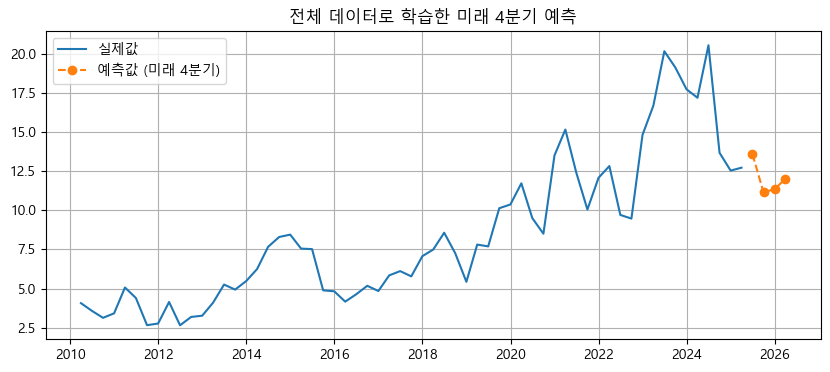

In [280]:
ratio_forecast_result = forecast_future_4q_with_sarima(merged_ratio_exog, date_col='date', value_col='endog_var', use_log=False)

🔍 총 64개의 SARIMAX 조합 평가 중...


100%|██████████| 64/64 [00:06<00:00,  9.67it/s]



✅ 최적 구조: order=(0, 1, 0), seasonal_order=(1, 1, 1, 4), AIC=242.70

📊 Ljung-Box Test (잔차의 자기상관 여부):
     lb_stat  lb_pvalue
4   0.818350   0.935971
8   3.952457   0.861387
12  7.723393   0.806356


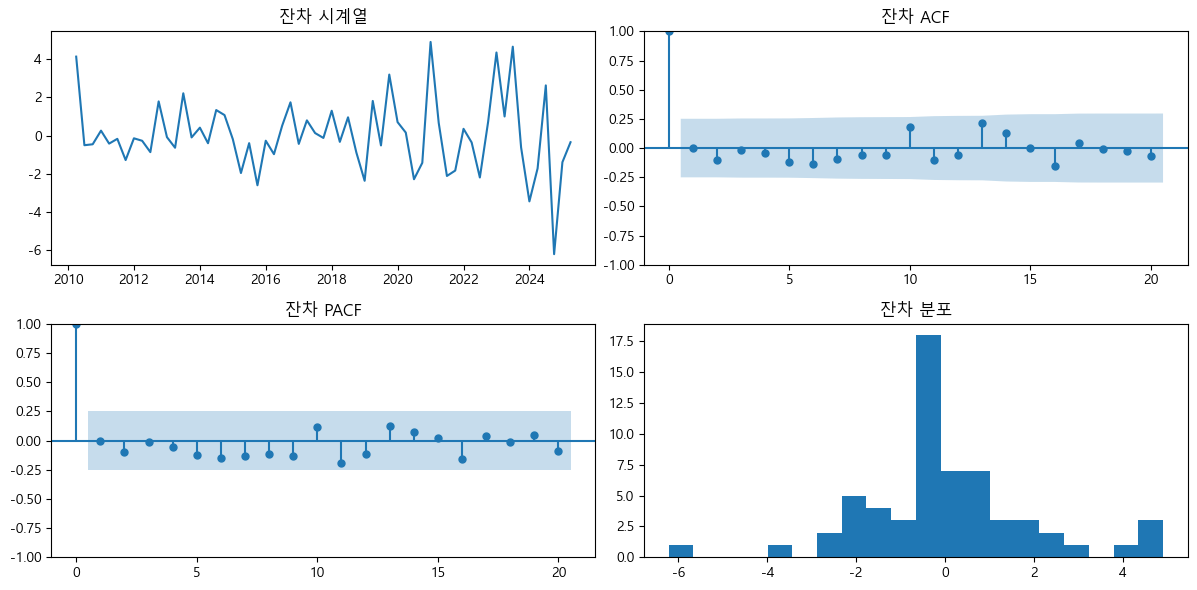

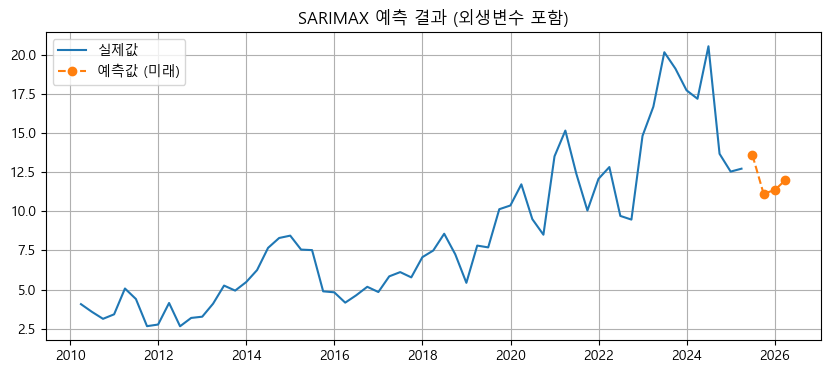

             forecast
date                 
2025-06-30  13.572994
2025-09-30  11.123432
2025-12-31  11.340808
2026-03-31  11.995177


In [281]:
ratio_forecast_result_exog = forecast_with_exog_sarimax(merged_ratio_exog, future_exog=future_exog_values, use_log=False)
print(ratio_forecast_result_exog)
ratio_forecast_result_exog.rename(columns={'forecast': 'ratio_forecast'}, inplace=True)

In [282]:
# 저장 디렉토리
base_dir = r"C:\Users\MetaM\PycharmProjects\stock_forecast\DATA"
os.makedirs(base_dir, exist_ok=True)

# 1️⃣ 기본 모델 저장
valuation_df = pd.concat([forecast_result, ratio_forecast_result], axis=1)
valuation_df['target_market_value'] = valuation_df['forecast'] * valuation_df['predicted_mean']

basic_save_path = os.path.join(base_dir, f"{tic_name}_valuation.xlsx")
valuation_df.to_excel(basic_save_path, index=False)
print(f"✅ 저장 완료: {basic_save_path}")

# 2️⃣ 외생변수 포함 모델 저장
valuation_df_exog = pd.concat([forecast_result, ratio_forecast_result_exog], axis=1)
valuation_df_exog['target_market_value'] = valuation_df_exog['forecast'] * valuation_df_exog['ratio_forecast']

exog_save_path = os.path.join(base_dir, f"{tic_name}_valuation_exog.xlsx")
valuation_df_exog.to_excel(exog_save_path, index=False)
print(f"✅ 저장 완료: {exog_save_path}")

✅ 저장 완료: C:\Users\MetaM\PycharmProjects\stock_forecast\DATA\MU_valuation.xlsx
✅ 저장 완료: C:\Users\MetaM\PycharmProjects\stock_forecast\DATA\MU_valuation_exog.xlsx


In [263]:
valuation_df

,forecast,predicted_mean,target_market_value
2025-06-30,1.518306e+09,6.535829,9.923392e+09
2025-09-30,1.557019e+09,6.688645,1.041435e+10
2025-12-31,1.622585e+09,7.399605,1.200648e+10
2026-03-31,1.621379e+09,7.552327,1.224518e+10


In [339]:
test_df = fetch_table_data(db_info, 'US_fundq')
extracted_data = test_df[test_df['ticker'] == tic_name][['date', 'saleq']]

✅ 'US_fundq' 테이블에서 1572228건의 데이터를 가져왔습니다.


,date,saleq
1365608,2000-01-31,0.000
1365609,2000-02-29,0.000
1365610,2000-03-31,615.358
1365611,2000-04-30,615.358
1365612,2000-05-31,615.358
...,...,...
1366207,2024-12-31,752.884
1366208,2025-01-31,752.884
1366209,2025-02-28,752.884
1366210,2025-03-31,685.680


<Axes: >

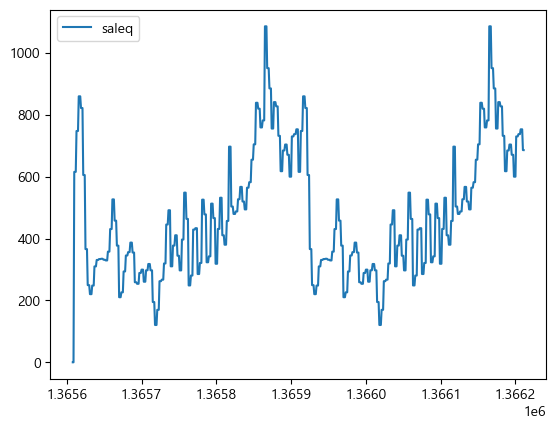

In [345]:
extracted_data = test_df[test_df['ticker'] == tic_name][['date', 'saleq']]
# extracted_data[['saleq']].plot()

In [344]:
endog_df.tail(24)

,date,TER
888,2019-06-30,5.641780e+08
902,2019-09-30,5.820380e+08
906,2019-12-31,6.546500e+08
916,2020-03-31,7.043550e+08
934,2020-06-30,8.386610e+08
951,2020-09-30,8.194840e+08
964,2020-12-31,7.589680e+08
984,2021-06-30,7.816060e+08
998,2021-09-30,1.085728e+09
1006,2021-12-31,8.850470e+08


In [ ]:
)